In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from gensim.models.word2vec import Word2VecKeyedVectors
from gensim.models.poincare import PoincareModel
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from collections import namedtuple
import itertools
import random
import sqlite3

## Model Training

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
%%time
model_poincare = PoincareModel.load("drive/My Drive/wiki_cat_poincare")
model_node2vec = Word2Vec.load("drive/My Drive/wiki_category_node2vec")
wiki_elmo = Word2VecKeyedVectors.load("drive/My Drive/wiki_cat_elmo.kv")

d:\python\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
d:\python\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
d:\python\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details

Wall time: 1min 21s


In [4]:
wiki_elmo

In [5]:
wiki_elmo["Logistic_regression"].shape

(2048,)

In [6]:
def load_categories(filepath):
    with open(filepath, encoding="utf-8") as fp:
        categories = []
        for line in fp:
            cat, level = line.strip().split("\t")
            level = int(level)
            categories.append((cat, level))
    return categories

def load_edges(filepath):
    with open(filepath, encoding="utf-8") as fp:
        edges = []
        for line in fp:
            cat1, cat2, level = line.strip().split("\t")
            level = int(level)
            edges.append((cat1, cat2, level))
    return edges

VOCAB_TUPLE=namedtuple("CATEGORY_VOCAB", "name2id id2name size")
def load_vocab(filename):
    with open(filename, encoding="utf-8") as fp:
        # replace space with underscore for wikipedia category names
        name2id = {line.strip().replace(" ", "_"): str(i) for i, line in enumerate(fp)}
        id2name = {v: k for k,v in name2id.items()}
    vocab=VOCAB_TUPLE(name2id=name2id, id2name=id2name, size=len(name2id))
    return vocab

In [7]:
invalid_categories = load_categories("drive/My Drive/CS_invalid_categories.txt")
invalid_edges = load_edges("drive/My Drive/CS_invalid_edges.txt")
print((f"{len(invalid_categories)} invalid categories, {len(invalid_edges)} invalid edges")) 

13330 invalid categories, 14832 invalid edges


In [8]:
wiki_category_vocab = load_vocab("drive/My Drive/categories.txt")
print((f"Found items in Wiki category vocab: name2id={len(wiki_category_vocab.name2id)}, "
      f"id2name={len(wiki_category_vocab.id2name)}"))

Found items in Wiki category vocab: name2id=1623862, id2name=1623862


In [9]:
def get_filtered_categories(edges, max_level=10):
    categories = dict()
    for e1, e2, level in edges:
        if level < max_level:
            for e in [e1, e2]:
                if e not in categories:
                    categories[e] = level
                categories[e] = min(level, categories[e])
    return [(k,v) for k,v in categories.items()]

In [2]:
result = pd.read_csv('drive/My Drive/plusmath.txt.gz', sep='\t')

d:\python\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
random.sample(result[result['Source_CAM']=='CSO']['CSO_ACM_MATH'].tolist(), 100)

['clinical decision support system',
 'discontinuous galerkin methods',
 'macro photography',
 'qr factorizations',
 'layered manufacturing',
 'interest point detection',
 'rijndael',
 'computer aided',
 'clock skews',
 'cell loss probability',
 'vision systems',
 'multihop wireless networks',
 'rate control scheme',
 'digital library',
 'acceleration data',
 'intrusion detection models',
 'lesser sunda islands',
 'adaptive robust control',
 'gm %281 %2c 1%29 model',
 'fault tolerance mechanisms',
 'single robots',
 'dynamic surface control',
 'reliability estimation',
 'anomaly detection methods',
 'hybrid algorithms',
 'optical transmission systems',
 'psychology',
 'partial differential',
 'gnss systems',
 'pattern classification problems',
 'multi-cell environment',
 'e-books',
 'knowledge base',
 'negative refraction',
 'bidirectional reflectance distribution functions',
 'computer hardware',
 'off-line handwritten',
 'm sequence',
 'flexibility increasing',
 'ultrasound contrast 

In [4]:
ACM_CSO_MATH = result[result['topic'].notnull() & result['CSO_ACM_MATH'].notnull()].drop_duplicates(subset='topic')
ACM_CSO_MATH = ACM_CSO_MATH['topic'].tolist()

In [5]:
len(ACM_CSO_MATH)

1756

In [13]:
invalid_category_level_dict = dict(get_filtered_categories(invalid_edges, max_level=20))
filtered_invalid_categories = [(cat, invalid_category_level_dict.get(cat, -1)) for cat, lvl in invalid_categories]
print((f"filtered_invalid_categories={len(filtered_invalid_categories)}"))

filtered_invalid_categories=13330


In [14]:
random.seed(9001)
filtered_invalid_categories = random.sample(filtered_invalid_categories, len(ACM_CSO_MATH))

In [15]:
def get_categories(categories, vocab): 
    return [vocab.name2id[c] for c in categories]

def get_categories_no_root(categories): 
    return [c for c, l in categories if c != '<CS_CATEGORY_TREE_ROOT>']

def process_model_data(
    categories_list, 
    vocab, 
    keyed_vectors_list, 
    skip_vocab_indexes=None
):
    categories_list = [categories_list[0], get_categories_no_root(categories_list[1])]
    vectors_list = [[] for i in range(len(categories_list))]
    skip_vocab_indexes = skip_vocab_indexes if skip_vocab_indexes is not None else set()
    for i, kv in enumerate(keyed_vectors_list):
        keys_list = [categories for categories in categories_list]
        if i not in skip_vocab_indexes:
            keys_list = [
                np.array(get_categories(categories, vocab)) 
                for categories in keys_list
            ]
        for vectors, keys in zip(vectors_list, keys_list):
            vectors.append(kv[keys])
    vectors_list = [np.hstack(vectors) for vectors in vectors_list]
    return vectors_list

def generate_training_data(
    valid_categories, 
    invalid_categories, 
    vocab, 
    keyed_vectors_list, 
    skip_vocab_indexes=None
):
    valid_vectors, invalid_vectors = process_model_data(
        [valid_categories, invalid_categories],
        vocab, 
        keyed_vectors_list, 
        skip_vocab_indexes=skip_vocab_indexes
    )
    X = np.vstack([valid_vectors, invalid_vectors])
    y = np.array([1]*valid_vectors.shape[0] + [0]*invalid_vectors.shape[0])
    assert X.shape[0] == y.shape[0], f"X.shape={X.shape} != y.shape={y.shape}"
    return X, y
    
def shuffle_data(X, y):
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]
    return X, y

def fit_model_factory(valid_categories, invalid_categories, vocab):
    def fit_model(model, keyed_vectors_list, skip_vocab_indexes=None):
        X, y = generate_training_data(
            valid_categories, 
            invalid_categories, 
            vocab, 
            keyed_vectors_list,
            skip_vocab_indexes=skip_vocab_indexes
        )
        X, y = shuffle_data(X, y)
        print(f"X={X.shape}, y={y.shape}")
        model.fit(X, y)
        return model
    return fit_model

def get_best_scores(model):
    idx = model.scores_[1].mean(axis=0).argmax()
    scores = model.scores_[1][idx]
    return scores

def get_best_scores_grid_cv(model):
    best_idx = model.best_index_
    scores = np.array([
        v[best_idx] 
        for k,v in model.cv_results_.items()
        if k.startswith("split") and k.endswith("_test_score")
    ])
    return scores

In [16]:
process_model_data([ACM_CSO_MATH[:10], filtered_invalid_categories[:10]], wiki_category_vocab, [wiki_elmo], skip_vocab_indexes={0})

[array([[ 0.53330475,  0.3724749 ,  0.18326128, ...,  0.0442834 ,
         -0.07866905, -0.279763  ],
        [ 0.02576309, -1.288788  ,  0.47129723, ...,  0.50043863,
          0.5432612 ,  0.18663418],
        [ 0.48170903, -0.41222218, -0.41077974, ...,  0.31421635,
          0.41238067,  0.33602262],
        ...,
        [-0.42042837,  0.5137127 ,  0.07200354, ...,  0.36752748,
         -0.10498727, -0.34930524],
        [-0.20327784, -0.1414965 , -0.6578411 , ...,  0.34086874,
          0.43355802,  0.16248415],
        [-0.3953828 ,  0.07015421, -0.30845022, ...,  1.036779  ,
         -0.3396132 , -0.26162317]], dtype=float32),
 array([[ 0.48246202,  0.44363722,  0.22045703, ...,  0.09762877,
         -0.18278502, -0.1542292 ],
        [ 0.3648303 ,  0.15510643, -0.37632433, ..., -0.06734087,
         -0.02446624,  0.35517716],
        [-0.6755624 , -0.38421583, -0.00824597, ...,  0.1598062 ,
          0.34564975,  0.5479979 ],
        ...,
        [ 0.24644716,  0.57163674,  0.0

In [17]:
model_scores = {}
model_best_params = {}

In [18]:
KEYWORD_CONFIG=namedtuple("KEYWORD_CONFIG", "kv_type kv_list skip_vocab_idx")

In [19]:
keyword_configs = [
    KEYWORD_CONFIG("poincare", [model_poincare.kv], skip_vocab_idx=None),
    KEYWORD_CONFIG("node2vec", [model_node2vec], skip_vocab_idx=None),
    KEYWORD_CONFIG("elmo", [wiki_elmo], skip_vocab_idx={0}),
    KEYWORD_CONFIG("poincare_node2vec", [model_poincare.kv, model_node2vec], skip_vocab_idx=None),
    KEYWORD_CONFIG("elmo_poincare", [wiki_elmo, model_poincare.kv], skip_vocab_idx={0}),
    KEYWORD_CONFIG("elmo_node2vec", [wiki_elmo, model_node2vec], skip_vocab_idx={0}),
    KEYWORD_CONFIG("elmo_poincare_node2vec", [wiki_elmo, model_poincare.kv, model_node2vec], skip_vocab_idx={0}),
]
keyword_configs

[KEYWORD_CONFIG(kv_type='poincare', kv_list=[<gensim.models.poincare.PoincareKeyedVectors object at 0x000001E5E2E73EF0>], skip_vocab_idx=None),
 KEYWORD_CONFIG(kv_type='node2vec', kv_list=[<gensim.models.word2vec.Word2Vec object at 0x000001E5AA5A0630>], skip_vocab_idx=None),
 KEYWORD_CONFIG(kv_type='elmo', kv_list=[<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000001E5AA5A0748>], skip_vocab_idx={0}),
 KEYWORD_CONFIG(kv_type='poincare_node2vec', kv_list=[<gensim.models.poincare.PoincareKeyedVectors object at 0x000001E5E2E73EF0>, <gensim.models.word2vec.Word2Vec object at 0x000001E5AA5A0630>], skip_vocab_idx=None),
 KEYWORD_CONFIG(kv_type='elmo_poincare', kv_list=[<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000001E5AA5A0748>, <gensim.models.poincare.PoincareKeyedVectors object at 0x000001E5E2E73EF0>], skip_vocab_idx={0}),
 KEYWORD_CONFIG(kv_type='elmo_node2vec', kv_list=[<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000001E5AA5A0748>, <gensi

In [20]:
fit_model = fit_model_factory(ACM_CSO_MATH, filtered_invalid_categories, wiki_category_vocab)

### Logistic Regression

In [21]:
%%time
for config in keyword_configs:
    model_type = "lr"
    key = (config.kv_type, model_type)
    print(key, config.skip_vocab_idx)
    model = LogisticRegressionCV(cv=10, n_jobs=10, scoring="f1")
    %time model = fit_model(model, config.kv_list, skip_vocab_indexes=config.skip_vocab_idx)
    model_scores[key] = get_best_scores(model)
    model_best_params[key] = model.C_
    print(model_scores[key])

('poincare', 'lr') None
X=(3512, 300), y=(3512,)
Wall time: 14.3 s
[0.80112045 0.79775281 0.79096045 0.83798883 0.83707865 0.84269663
 0.85245902 0.83018868 0.8310992  0.82887701]
('node2vec', 'lr') None


d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


X=(3512, 300), y=(3512,)
Wall time: 6.56 s
[0.79765396 0.80232558 0.8255814  0.83236994 0.85142857 0.83852691
 0.83615819 0.83286119 0.83286119 0.83286119]
('elmo', 'lr') {0}
X=(3512, 2048), y=(3512,)
Wall time: 50.8 s
[0.8150289  0.85955056 0.89577465 0.89635854 0.88268156 0.86516854
 0.85875706 0.85633803 0.85633803 0.85393258]
('poincare_node2vec', 'lr') None
X=(3512, 600), y=(3512,)


d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 15 s
[0.82697947 0.83040936 0.82840237 0.90502793 0.89635854 0.8988764
 0.88515406 0.87640449 0.87078652 0.86908078]
('elmo_poincare', 'lr') {0}
X=(3512, 2348), y=(3512,)


d:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 58.5 s
[0.87955182 0.88888889 0.90858726 0.90659341 0.87640449 0.86908078
 0.86980609 0.86426593 0.8603352  0.86350975]
('elmo_node2vec', 'lr') {0}
X=(3512, 2348), y=(3512,)


d:\python\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 59.7 s
[0.84530387 0.88219178 0.9010989  0.88202247 0.89265537 0.89014085
 0.88450704 0.88700565 0.88700565 0.88700565]
('elmo_poincare_node2vec', 'lr') {0}
X=(3512, 2648), y=(3512,)
Wall time: 1min 9s
[0.87323944 0.90285714 0.93948127 0.94555874 0.92528736 0.9226361
 0.92528736 0.9221902  0.9221902  0.9221902 ]
Wall time: 4min 34s


### MLP models

In [22]:
mlp_param_grid=dict(
    hidden_layer_sizes=[
    tuple(2**k for k in range(j, i+1))[::-1]
    for i in range(5, 8)
    for j in range(5, i+1)
])
mlp_param_grid

{'hidden_layer_sizes': [(32,),
  (64, 32),
  (64,),
  (128, 64, 32),
  (128, 64),
  (128,)]}

In [23]:
%%time
for config in keyword_configs:
    model_type = "mlp"
    key = (config.kv_type, model_type)
    print(key, config.skip_vocab_idx)

    model = GridSearchCV(
        MLPClassifier(solver='lbfgs'),
        param_grid=mlp_param_grid,
        cv=10,
        scoring = 'f1',
        n_jobs=10
    )
    %time model = fit_model(model, config.kv_list, skip_vocab_indexes=config.skip_vocab_idx)
    model_scores[key] = get_best_scores_grid_cv(model)
    model_best_params[key] = model.best_params_
    print(model_scores[key])

('poincare', 'mlp') None
X=(3512, 300), y=(3512,)
Wall time: 4min 31s
[0.89458689 0.86813187 0.87830688 0.86178862 0.85479452 0.85227273
 0.89502762 0.86931818 0.86426593 0.88767123]
('node2vec', 'mlp') None
X=(3512, 300), y=(3512,)


d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 3min 5s
[0.87150838 0.84699454 0.77647059 0.87931034 0.83775811 0.85386819
 0.8265896  0.84813754 0.80924855 0.84090909]
('elmo', 'mlp') {0}
X=(3512, 2048), y=(3512,)
Wall time: 8min 1s
[0.89577465 0.90909091 0.89635854 0.9017341  0.90285714 0.89635854
 0.89534884 0.88319088 0.89750693 0.85964912]
('poincare_node2vec', 'mlp') None
X=(3512, 600), y=(3512,)


d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 5min 10s
[0.87955182 0.88202247 0.85154062 0.83573487 0.85294118 0.85465116
 0.81948424 0.85217391 0.86455331 0.80672269]
('elmo_poincare', 'mlp') {0}
X=(3512, 2348), y=(3512,)
Wall time: 8min 16s
[0.91412742 0.89913545 0.89014085 0.89204545 0.88764045 0.8907563
 0.90196078 0.89714286 0.89518414 0.91477273]
('elmo_node2vec', 'mlp') {0}
X=(3512, 2348), y=(3512,)


d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 7min 54s
[0.89014085 0.90250696 0.90084986 0.93714286 0.90857143 0.93409742
 0.89971347 0.9154519  0.90379009 0.92134831]
('elmo_poincare_node2vec', 'mlp') {0}
X=(3512, 2648), y=(3512,)


d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 8min 15s
[0.94677871 0.92394366 0.90607735 0.89830508 0.91208791 0.90502793
 0.89940828 0.8908046  0.88823529 0.89714286]
Wall time: 45min 15s


### Cross_Validation Result for Grid Search

In [24]:
df_t = pd.DataFrame(model_scores)
df_t.describe()

,poincare,node2vec,elmo,poincare_node2vec,elmo_poincare,elmo_node2vec,elmo_poincare_node2vec,poincare,node2vec,elmo,poincare_node2vec,elmo_poincare,elmo_node2vec,elmo_poincare_node2vec
,lr,lr,lr,lr,lr,lr,lr,mlp,mlp,mlp,mlp,mlp,mlp,mlp
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.825022,0.828263,0.863993,0.868748,0.878702,0.883894,0.920092,0.872616,0.839079,0.893787,0.849938,0.898291,0.911361,0.906781
std,0.020903,0.016335,0.023738,0.030112,0.017414,0.014670,0.019973,0.015611,0.029822,0.013706,0.023934,0.009564,0.015413,0.017462
min,0.790960,0.797654,0.815029,0.826979,0.860335,0.845304,0.873239,0.852273,0.776471,0.859649,0.806723,0.887640,0.890141,0.888235
25%,0.808060,0.827279,0.856338,0.840077,0.865470,0.882771,0.922190,0.862408,0.829382,0.895455,0.839686,0.891079,0.901264,0.897433
50%,0.830644,0.832861,0.859154,0.873596,0.873105,0.887006,0.922413,0.868725,0.843952,0.896359,0.852558,0.896163,0.906181,0.902218
75%,0.837761,0.835334,0.878303,0.893557,0.886555,0.889357,0.925287,0.885330,0.852436,0.900677,0.862078,0.901254,0.919874,0.910585
max,0.852459,0.851429,0.896359,0.905028,0.908587,0.901099,0.945559,0.895028,0.879310,0.909091,0.882022,0.914773,0.937143,0.946779


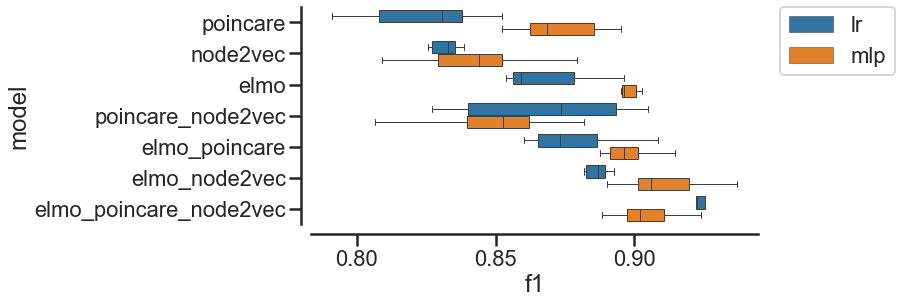

In [25]:
plt.figure(figsize=(8,4))
sns.boxplot(
    x="f1", y="model", 
    data=df_t.melt(var_name=["model", "model_type"], value_name="f1"),
    hue="model_type",
    width=0.8,
    linewidth=1,
    showfliers=False,
)
sns.despine(offset=10)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [26]:
df_t.describe().loc["mean"].sort_values()

poincare                lr     0.825022
node2vec                lr     0.828263
                        mlp    0.839079
poincare_node2vec       mlp    0.849938
elmo                    lr     0.863993
poincare_node2vec       lr     0.868748
poincare                mlp    0.872616
elmo_poincare           lr     0.878702
elmo_node2vec           lr     0.883894
elmo                    mlp    0.893787
elmo_poincare           mlp    0.898291
elmo_poincare_node2vec  mlp    0.906781
elmo_node2vec           mlp    0.911361
elmo_poincare_node2vec  lr     0.920092
Name: mean, dtype: float64

In [27]:
model_best_params

{('poincare', 'lr'): array([21.5443469]),
 ('node2vec', 'lr'): array([0.35938137]),
 ('elmo', 'lr'): array([0.00599484]),
 ('poincare_node2vec', 'lr'): array([0.04641589]),
 ('elmo_poincare', 'lr'): array([0.04641589]),
 ('elmo_node2vec', 'lr'): array([0.04641589]),
 ('elmo_poincare_node2vec', 'lr'): array([0.04641589]),
 ('poincare', 'mlp'): {'hidden_layer_sizes': (64,)},
 ('node2vec', 'mlp'): {'hidden_layer_sizes': (64,)},
 ('elmo', 'mlp'): {'hidden_layer_sizes': (64,)},
 ('poincare_node2vec', 'mlp'): {'hidden_layer_sizes': (128, 64, 32)},
 ('elmo_poincare', 'mlp'): {'hidden_layer_sizes': (64, 32)},
 ('elmo_node2vec', 'mlp'): {'hidden_layer_sizes': (64, 32)},
 ('elmo_poincare_node2vec', 'mlp'): {'hidden_layer_sizes': (128, 64)}}

### Save model training data

In [28]:
df_t.to_csv("drive/My Drive/category_prediction_models_balanced.txt", sep="\t", index=False)

In [29]:
import json

with open("drive/My Drive/best_params_balanced.json", "w+", encoding="utf-8") as fp:
    json.dump({
        "_".join(k): list(v) if isinstance(v, np.ndarray) else v
        for k,v in model_best_params.items()
    }, fp, indent=2)

##### See unbalanced model traning in another notebook (unbalanced)

## Model Evaluation and Analysis

### Balanced model

In [30]:
def process_model_data1(
    categories_list, 
    vocab, 
    keyed_vectors_list, 
    skip_vocab_indexes=None
):
    categories_list = [categories_list[0], categories_list[1]]
    vectors_list = [[] for i in range(len(categories_list))]
    skip_vocab_indexes = skip_vocab_indexes if skip_vocab_indexes is not None else set()
    for i, kv in enumerate(keyed_vectors_list):
        keys_list = [categories for categories in categories_list]
        if i not in skip_vocab_indexes:
            keys_list = [
                np.array(get_categories(categories, vocab)) 
                for categories in keys_list
            ]
        for vectors, keys in zip(vectors_list, keys_list):
            vectors.append(kv[keys])
    vectors_list = [np.hstack(vectors) for vectors in vectors_list]
    return vectors_list

In [31]:
import json
conn = sqlite3.connect('drive/My Drive/annotation_data.db')

query = """SELECT a.*, b.*, c.* FROM annotations AS a
JOIN annotation_data AS b ON a.annotation_data_id = b.data_id
JOIN annotator_info AS c ON a.annotator_id = c.annotator_id;"""
df = pd.read_sql_query(query, conn)
df = pd.concat([
    df.loc[:,~df.columns.duplicated()], 
    pd.io.json.json_normalize(df.submission.apply(json.loads))
], axis=1).rename(columns={"value": "label"})

df_t = df[df.label == "all_valid"].groupby("data_id")[["parent", "child"]].first()
valid_anno = list(set(df_t.parent.unique().tolist()) | set(df_t.child.unique().tolist()) | set(df[df.label == "invalid_child"].groupby("data_id")["parent"].first().unique().tolist()))
invalid_anno = (set(df.parent.unique().tolist()) | set(df.child.unique().tolist())) - set(valid_anno)

In [1]:
len(valid_anno)

NameError: name 'valid_anno' is not defined

In [32]:
def model_pred(valid_categories, invalid_categories, predictor):
    vectors = process_model_data1(
    [valid_anno, invalid_anno],
    wiki_category_vocab,
    best_config.kv_list, 
    skip_vocab_indexes=best_config.skip_vocab_idx
    )
    
    valid_pred = model.predict_proba(vectors[0]).argmax(axis=1)
    valid_true = np.ones_like(valid_pred)


    invalid_pred = model.predict_proba(vectors[1]).argmax(axis=1)
    invalid_true = np.zeros_like(invalid_pred)

    y_true = np.hstack([valid_true, invalid_true])
    y_pred = np.hstack([valid_pred, invalid_pred])
    return y_true, y_pred
    
    

def get_classification_report(pred):    
    print(confusion_matrix(pred[0], pred[1]))
    print(classification_report(pred[0], pred[1], target_names=["invalid", "valid"]))
    

def pd_result(valid_anno, invalid_anno, model):
    result = model_pred(valid_anno, invalid_anno, model)
    result = {"category": np.hstack([valid_anno, list(invalid_anno)]),
              "y_actual": result[0],
              "y_predict" : result[1]}
    result = pd.DataFrame(result)
    return result

In [33]:
with open("drive/My Drive/best_params_balanced.json") as fp:
    model_best_params = json.load(fp)

In [34]:
KEYWORD_CONFIG=namedtuple("KEYWORD_CONFIG", "kv_type kv_list skip_vocab_idx")
best_config = KEYWORD_CONFIG("elmo_node2vec", [wiki_elmo, model_node2vec], skip_vocab_idx={0})

best_model_type = "mlp"
best_model_key = f"{best_config.kv_type}_{best_model_type}"
best_model_params = model_best_params[best_model_key]
best_model_params

{'hidden_layer_sizes': [64, 32]}

In [35]:
cate = pd.read_csv('drive/My Drive/categories.txt', sep='\t', header=None, names=['topic'])

invalid_cate = [
    'microsoft',
    'windows',
    'linux',
    'macos',
    'studios',
    ' ios',
    'ios '
    'analyst',
    'device',
    'software',
    'google',
    'Samsung',
    'games',
    'companies',
    'journal',
    'conference',
    'Yahoo',
    'libraries',
    'website',
    'award',
    'researcher',
    'station',
    'amazon',
    'android',
    'twitter'
]


aaa = invalid_cate[0]
for i in range(len(invalid_cate)):
    aaa = aaa+ '|' +invalid_cate[i]

cate['tf'] = cate['topic'].str.contains(aaa, case = False)
inva_cate = cate[cate['tf'] == 1]['topic'].str.replace(' ', '_').tolist()
invalid_add = []
for i in range(len(inva_cate)):
    invalid_add = invalid_add + [(inva_cate[i], 0)]

In [49]:
invalid_categories = load_categories("drive/My Drive/CS_invalid_categories.txt")
invalid_edges = load_edges("drive/My Drive/CS_invalid_edges.txt")
wiki_category_vocab = load_vocab("drive/My Drive/categories.txt")
invalid_category_level_dict = dict(get_filtered_categories(invalid_edges, max_level=20))
filtered_invalid_categories = [(cat, invalid_category_level_dict.get(cat, -1)) for cat, lvl in invalid_categories]
random.seed(9001)
filtered_invalid_categories = random.sample(filtered_invalid_categories, len(ACM_CSO_MATH))
model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(64))
fit_model = fit_model_factory(ACM_CSO_MATH, filtered_invalid_categories, wiki_category_vocab)
model = fit_model(model, best_config.kv_list, skip_vocab_indexes=best_config.skip_vocab_idx)

d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


X=(3512, 2348), y=(3512,)


#### Confusion Matrix

In [50]:
get_classification_report(model_pred(valid_anno, invalid_anno, model))

[[ 259  139]
 [ 210 1495]]
              precision    recall  f1-score   support

     invalid       0.55      0.65      0.60       398
       valid       0.91      0.88      0.90      1705

    accuracy                           0.83      2103
   macro avg       0.73      0.76      0.75      2103
weighted avg       0.85      0.83      0.84      2103



d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


#### Misclassification

In [31]:
balance = pd_result(valid_anno, invalid_anno, model)

d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [32]:
balance[balance["y_actual"].isin([0]) & balance["y_predict"].isin([1])]

,category,y_actual,y_predict
1711,Gmail,0,1
1721,Macintosh_firmware,0,1
1727,Angle_measuring_instruments,0,1
1728,Sharp_programmable_calculators,0,1
1729,Yahoo!_Search,0,1
1733,People_associated_with_the_finite_element_method,0,1
1739,Inactive_massively_multiplayer_online_games,0,1
1745,Windows_Server,0,1
1750,Numerical_analysts,0,1
1752,Android_(operating_system)_devices,0,1


In [33]:
balance[balance["y_actual"].isin([1]) & balance["y_predict"].isin([0])]

,category,y_actual,y_predict
3,Theorems_regarding_stochastic_processes,1,0
4,Thermodynamic_diagrams,1,0
20,Graph_description_languages,1,0
24,Graphs_by_chromatic_number,1,0
38,Graphs_(images),1,0
51,M-type_bright_giants,1,0
70,Internet_privacy_software,1,0
71,Mathematical_analysts,1,0
75,Measures_of_complexity,1,0
77,People_associated_with_computer_security,1,0


In [34]:
conn = sqlite3.connect('drive/My Drive/annotation_data.09132019.db')

query = """SELECT a.*, b.*, c.* FROM annotations AS a
JOIN annotation_data AS b ON a.annotation_data_id = b.data_id
JOIN annotator_info AS c ON a.annotator_id = c.annotator_id;"""
df = pd.read_sql_query(query, conn)
df = pd.concat([
    df.loc[:,~df.columns.duplicated()], 
    pd.io.json.json_normalize(df.submission.apply(json.loads))
], axis=1).rename(columns={"value": "label"})

In [35]:
df = df[df['last_update'] > '2019-08-17']

In [36]:
df_t = df[df.label == "all_valid"].groupby("data_id")[["parent", "child"]].first()
valid_anno = list(set(df_t.parent.unique().tolist()) | set(df_t.child.unique().tolist()) | set(df[df.label == "invalid_child"].groupby("data_id")["parent"].first().unique().tolist()))
invalid_anno = (set(df.parent.unique().tolist()) | set(df.child.unique().tolist())) - set(valid_anno)

In [37]:
get_classification_report(model_pred(valid_anno, invalid_anno, model))

d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[[239 111]
 [157 971]]
              precision    recall  f1-score   support

     invalid       0.60      0.68      0.64       350
       valid       0.90      0.86      0.88      1128

    accuracy                           0.82      1478
   macro avg       0.75      0.77      0.76      1478
weighted avg       0.83      0.82      0.82      1478



In [38]:
balance = pd_result(valid_anno, invalid_anno, model)

d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [39]:
invalid_cate = [
    'microsoft',
    'windows',
    'linux',
    'macos',
    'studios',
    '_ios',
    'ios_'
    'analyst',
    'device',
    'software',
    'google',
    'Samsung',
    'games',
    'companies',
    'journal',
    'conference',
    'Yahoo',
    'libraries',
    'website',
    'award',
    'researcher',
    'station',
    'amazon',
    'android',
    'twitter'
]

valid_cate = [
    'computational',
    'language',
    'Theorem',
    'computer_science',
    'theory'
]

aaa = invalid_cate[0]
for i in range(len(invalid_cate)):
    aaa = aaa+ '|' +invalid_cate[i]

bbb = valid_cate[0]
for i in range(len(valid_cate)):
    bbb = bbb+ '|' +valid_cate[i]

In [40]:
balance['tf'] = balance['category'].str.contains(bbb, case = False)
index = balance[balance['tf'].isin([1]) & balance['y_predict'].isin([0])]['y_predict'].index
balance['y_predict'][index] = 1

balance['tf'] = balance['category'].str.contains(aaa, case = False)
index = balance[balance['tf'].isin([1]) & balance['y_predict'].isin([1])]['y_predict'].index
balance['y_predict'][index] = 0

d:\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\python\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [41]:
print(confusion_matrix(balance['y_actual'], balance['y_predict']))
print(classification_report(balance['y_actual'], balance['y_predict'], target_names=["invalid", "valid"]))

[[285  65]
 [178 950]]
              precision    recall  f1-score   support

     invalid       0.62      0.81      0.70       350
       valid       0.94      0.84      0.89      1128

    accuracy                           0.84      1478
   macro avg       0.78      0.83      0.79      1478
weighted avg       0.86      0.84      0.84      1478



In [212]:
275/(275+75)

0.7857142857142857

In [213]:
balance[balance['y_actual'].isin([0]) & balance['y_predict'].isin([1])]

,category,y_actual,y_predict,tf
1146,Spyware_removal,0,1,False
1151,Candelabra,0,1,False
1157,Library_of_Congress_Classification,0,1,False
1158,Peer_review,0,1,False
1162,Works_about_the_Internet,0,1,False
1164,AutoCAD,0,1,False
1165,Immortality,0,1,False
1168,Mathematical_projects,0,1,False
1171,GLib,0,1,False
1185,Game_designers,0,1,False


### Unbalanced Model

In [42]:
with open("drive/My Drive/best_params_unbalanced.json") as fp:
    model_best_params = json.load(fp)

In [43]:
KEYWORD_CONFIG=namedtuple("KEYWORD_CONFIG", "kv_type kv_list skip_vocab_idx")

best_config = KEYWORD_CONFIG("elmo_node2vec", [wiki_elmo, model_node2vec], skip_vocab_idx={0})

best_model_type = "mlp"
best_model_key = f"{best_config.kv_type}_{best_model_type}"
best_model_params = model_best_params[best_model_key]
best_model_params

{'hidden_layer_sizes': [128]}

In [44]:
invalid_categories = load_categories("drive/My Drive/CS_invalid_categories.txt")
invalid_edges = load_edges("drive/My Drive/CS_invalid_edges.txt")
wiki_category_vocab = load_vocab("drive/My Drive/categories.txt")
invalid_category_level_dict = dict(get_filtered_categories(invalid_edges, max_level=20))
filtered_invalid_categories = [(cat, invalid_category_level_dict.get(cat, -1)) for cat, lvl in invalid_categories]

model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(128))
fit_model = fit_model_factory(ACM_CSO_MATH, (filtered_invalid_categories + invalid_add), wiki_category_vocab)
model = fit_model(model, best_config.kv_list, skip_vocab_indexes=best_config.skip_vocab_idx)

d:\python\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


X=(72169, 2348), y=(72169,)


#### Confusion Matrix

In [224]:
get_classification_report(model_pred(valid_anno, invalid_anno, model))

[[263  87]
 [297 831]]
              precision    recall  f1-score   support

     invalid       0.47      0.75      0.58       350
       valid       0.91      0.74      0.81      1128

    accuracy                           0.74      1478
   macro avg       0.69      0.74      0.70      1478
weighted avg       0.80      0.74      0.76      1478



d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [45]:
get_classification_report(model_pred(valid_anno, invalid_anno, model))

[[321  29]
 [378 750]]
              precision    recall  f1-score   support

     invalid       0.46      0.92      0.61       350
       valid       0.96      0.66      0.79      1128

    accuracy                           0.72      1478
   macro avg       0.71      0.79      0.70      1478
weighted avg       0.84      0.72      0.75      1478



d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


#### Misclassification

In [46]:
unbalance = pd_result(valid_anno, invalid_anno, model)

d:\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [45]:
unbalance[unbalance["y_actual"].isin([0]) & unbalance["y_predict"].isin([1])]

,category,y_actual,y_predict
1733,PDF_software,0,1
1737,Windows_Server,0,1
1745,Atmosphere,0,1
1750,Biogeomorphology,0,1
1754,WhatsApp,0,1
1757,Windows_emulation_software,0,1
1760,Human-based_computation_games,0,1
1766,Moscovium,0,1
1776,Satellite_radio_stations,0,1
1780,MacOS_user_interface,0,1


In [46]:
unbalance[unbalance["y_actual"].isin([1]) & unbalance["y_predict"].isin([0])]

,category,y_actual,y_predict
0,Unicode_typefaces,1,0
3,Hydrology_models,1,0
7,Programming_languages,1,0
11,Superlatives,1,0
13,Fields_of_mathematics,1,0
15,SMT_solvers,1,0
16,Minicomputers,1,0
18,Scientific_simulation_software,1,0
31,Applications_of_distributed_computing,1,0
33,Scientific_classification,1,0


1. Our use of ACM_CSO_MATH as valid categories for model training seems to be a good choice since the precision and recall for valid categories are pretty high. 

2. Since the invalid categories we used for model training are filtered through previous methods, the precision and recall for categories are not good enough. 

In [50]:
unbalance['tf'] = unbalance['category'].str.contains(bbb, case = False)
index = unbalance[unbalance['tf'].isin([1]) & unbalance['y_predict'].isin([0])]['y_predict'].index
unbalance['y_predict'][index] = 1

unbalance['tf'] = unbalance['category'].str.contains(aaa, case = False)
index = unbalance[unbalance['tf'].isin([1]) & unbalance['y_predict'].isin([1])]['y_predict'].index
unbalance['y_predict'][index] = 0

d:\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\python\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [51]:
print(confusion_matrix(unbalance['y_actual'], unbalance['y_predict']))
print(classification_report(unbalance['y_actual'], unbalance['y_predict'], target_names=["invalid", "valid"]))

[[321  29]
 [337 791]]
              precision    recall  f1-score   support

     invalid       0.49      0.92      0.64       350
       valid       0.96      0.70      0.81      1128

    accuracy                           0.75      1478
   macro avg       0.73      0.81      0.72      1478
weighted avg       0.85      0.75      0.77      1478



In [230]:
unbalance[unbalance['y_actual'].isin([0]) & unbalance['y_predict'].isin([1])]

,category,y_actual,y_predict,tf
1146,Spyware_removal,0,1,False
1158,Peer_review,0,1,False
1164,AutoCAD,0,1,False
1168,Mathematical_projects,0,1,False
1171,GLib,0,1,False
1185,Game_designers,0,1,False
1193,Life_extension,0,1,False
1217,Computational_physicists,0,1,False
1236,Portable_media_players,0,1,False
1239,Unix,0,1,False


In [50]:
inva_cate = []
for i in range(len(invalid_cate)):
    cate['tf'] = cate['topic'].str.contains(invalid_cate[i], case = False)
    inva_cate = inva_cate + cate[cate['tf'] == 1]['topic'].str.replace(' ', '_').tolist()

In [51]:
invalid_add = []
for i in range(len(inva_cate)):
    invalid_add = invalid_add + [(inva_cate[i], 0)]

d:\python\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


NameError: name 'b' is not defined

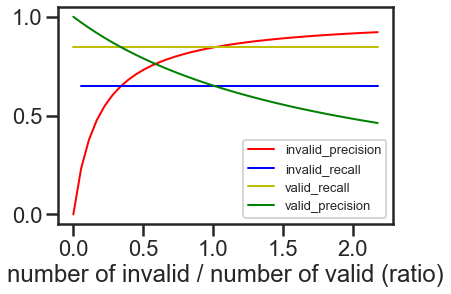

In [52]:
invalid_precision = np.arange(0, 10, 0.25)
valid_precision = np.arange(0, 10, 0.25)
invalid_recall = np.arange(0, 10, 0.25)
valid_recall = np.arange(0, 10, 0.25)
tp = 1963
tn = 433
fp = 234
fn = 357

a = np.arange(0, 10, 0.25)

for i in range(len(a)):
    invalid_precision[i] = tn * a[i]  / (tn * a[i] + fn)
    invalid_recall[i] = tn * a[i] / (tn * a[i] + fp * a[i])
    valid_precision[i] = tp / (tp + fp * a[i])
    valid_recall[i] = tp / (tp + fn)

ll = a * 667 / 2987

plt.plot(ll, invalid_precision,
         linewidth = 2, color='r', label='invalid_precision')
plt.legend(loc='lower right', prop={'size': 13})
plt.plot(ll, invalid_recall,
         linewidth = 2, color='b', label='invalid_recall')
plt.legend(loc='lower right', prop={'size': 13})
plt.plot(ll, valid_recall,
         linewidth = 2, color='y', label='valid_recall')
plt.legend(loc='lower right', prop={'size': 13})
plt.plot(ll, valid_precision,
         linewidth = 2, color='g', label='valid_precision')
plt.legend(loc='lower right', prop={'size': 13})
plt.xlabel('number of invalid / number of valid (ratio)')


invalid_precision = tn * a / (tn * a + fp * b)
invalid_recall = tn * a / (tn * a + fn * b)
valid_precision = tp * a / (tp * a + fp * b)
valid_recall = tp * a / (tp * a + fp * b)

In [52]:
cate

,topic,tf
0,!!! albums,False
1,!T.O.O.H.! albums,False
2,A-Class Wikipedia books,False
3,B-Class Wikipedia books,False
4,C-Class Wikipedia books,False
5,FA-Class Wikipedia books,False
6,GA-Class Wikipedia books,False
7,"Islam in and ""Islamism in"" templates",False
8,Part of a series on sidebar templates,False
9,Related ethnic groups needing confirmation,False


In [93]:
cate = pd.read_csv('drive/My Drive/categories.txt', sep='\t', header=None, names=['topic'])
ccate = cate['topic'].str.replace(' ', '_').tolist()
A-Class_Wikipedia_books

In [ ]:
process_model_data([ccate[47:], filtered_invalid_categories], wiki_category_vocab, best_config.kv_list, skip_vocab_indexes=best_config.skip_vocab_idx)

In [72]:
vectors[0]

array([[-0.16503994, -0.56334823, -0.02273896, ..., -0.17552415,
         0.08405666, -0.1776558 ],
       [-0.01726696,  0.29516086, -0.27514443, ..., -0.19298354,
        -0.08020089, -0.03944631],
       [-0.77126807,  0.18447964,  0.7454409 , ..., -0.24142581,
        -0.05270056, -0.13759127],
       ...,
       [ 0.22297978,  0.35557482, -0.3153254 , ..., -0.42124432,
         0.17153981, -0.2751476 ],
       [-0.41006434, -0.2642107 ,  0.07756677, ..., -0.15715873,
         0.10117658,  0.29409754],
       [-0.20256191, -0.06649101, -0.36408773, ...,  0.06029744,
         0.05584809,  0.00301652]], dtype=float32)